In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import distributions
import torchvision
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt


In [2]:
train = datasets.MNIST("../data/", train=True, download=True, transform=transforms.ToTensor())
test = datasets.MNIST("../data/", train=False, download=True, transform=transforms.ToTensor())

In [3]:
IM_SIZE = 28 * 28
IM_SHAPE = (28, 28)
CPU_training = False
BATCH = 64
EPOCHS = 50

use_cuda =  torch.cuda.is_available() and not CPU_training
device = torch.device("cuda" if use_cuda else "cpu")

trainset = torch.utils.data.DataLoader(train, batch_size=BATCH, shuffle=True, num_workers=7, pin_memory=use_cuda)
testset = torch.utils.data.DataLoader(test, batch_size=BATCH, shuffle=False, num_workers=7, pin_memory=use_cuda)

In [4]:
def nets(size): 
    return nn.Sequential(nn.Linear(size, 128),
                         nn.ReLU(True), 
                         nn.Linear(128, size),
                         nn.Sigmoid())

def nett(size):
    return nn.Sequential(nn.Linear(size, 128),
                         nn.ReLU(True), 
                         nn.Linear(128, size))

class CouplingLayer(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.size = size // 2 
        self.translate = nett(self.size)
        self.scale = nets(self.size)
        
    def forward(self, args):
        x, log_det_J = args
        x1, x2 = torch.split(x, self.size, 1)
        s = self.scale(x1)
        t = self.translate(x1)
        y2 = x2 * torch.exp(s) + t
        y = torch.cat((y2, x1), 1)
        log_det_J += s.sum(dim=1)
        return y, log_det_J

    def inverse(self, y):
        y1, y2 = torch.split(y, self.size, 1)      
        s = self.scale(y2)
        t = self.translate(y2)
        x1 = (y1 - t) * torch.exp(-s)
        return torch.cat((y2, x1), 1) 
    
class CouplingLayer_nice(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.size = size // 2 
        self.translate = nett(self.size)
        
    def forward(self, x):
        x1, x2 = torch.split(x, self.size, 1)       
        t = self.translate(x1)
        y2 = x2 + t
        return torch.cat((y2, x1), 1)

    def inverse(self, y):
        y1, y2 = torch.split(y, self.size, 1)         
        t = self.translate(y2)
        x1 = y1 - t
        return torch.cat((y2, x1), 1)
    
class HH(nn.Module):
    def __init__(self, size, num_vectors=None):
        super().__init__()
        self.size = size
        self.num_vectors = num_vectors or 2 * (self.size // 2 + 1)
        self.vectors = nn.Parameter(torch.Tensor(self.num_vectors, self.size, 1))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.uniform_(self.vectors, -1, 1)
        self.vectors.data.copy_(self.vectors / self.vectors.norm(dim=1, keepdim=True))

    def forward(self, x):
        Q = self.bmm_naive_cascade()
        return x @ Q.t()

    def inverse(self, x):
        Q = self.bmm_naive_cascade()
        return x @ Q

    # Householder transformation
    def _get_bmm_householder_matrices(self):
        N, S, _ = self.vectors.size()

        outer = torch.bmm(self.vectors, self.vectors.transpose(1, 2))
        inner = torch.bmm(self.vectors.transpose(1, 2), self.vectors)
        I = torch.eye(S, device=self.vectors.device).expand(N, -1, -1)
        hh_matrices = I - 2 * outer / (inner + 1e-16)
        return hh_matrices

    @staticmethod
    def _reduce_mm(matrices):
        Q = matrices[0]
        for M in matrices[1:]:
            Q = torch.mm(Q, M)
        return Q


    def bmm_naive_cascade(self):
        """
        Args:   
            vectors: [NumVectors, Size, 1]
        Output:
            Q: [Size, Size]
        """
        matrices = self._get_bmm_householder_matrices()
        return HH._reduce_mm(matrices)

In [5]:
class RealNVP(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.prior = distributions.MultivariateNormal(torch.zeros(size, device=device), torch.eye(size, device=device))
        self.encoder = nn.Sequential(CouplingLayer(size),
                                     HH(size, 5),
                                     CouplingLayer(size),
                                     HH(size, 5),
                                     CouplingLayer(size), 
                                     HH(size, 5),
                                     CouplingLayer(size),
                                     HH(size, 5),
                                     CouplingLayer(size), 
                                     HH(size, 5),
                                     CouplingLayer(size), 
                                     HH(size, 5),
                                     CouplingLayer(size), 
                                     HH(size, 5),
                                     CouplingLayer(size), 
                                     HH(size, 5),
                                     CouplingLayer(size), 
                                     HH(size, 5),
                                     CouplingLayer(size), 
                                     HH(size, 5),
                                     CouplingLayer(size), 
                                     HH(size, 5),
                                     CouplingLayer(size), 
                                     HH(size, 5),
                                     CouplingLayer(size), 
                                     HH(size, 5),
                                     CouplingLayer(size), 
                                     HH(size, 5),
                                     CouplingLayer(size), 
                                     HH(size, 5),
                                     CouplingLayer(size), 
                                     HH(size, 5),
                                     CouplingLayer(size),
                                     HH(size, 5),
                                     CouplingLayer(size), 
                                     HH(size, 5),
                                     CouplingLayer(size), 
                                     HH(size, 5),
                                     CouplingLayer(size), 
                                     HH(size, 5),
                                     CouplingLayer(size),                                   
                                     HH(size, 5),
                                     CouplingLayer(size))
    
    def forward(self, x):
        log_det_J = x.new_zeros(x.shape[0])
        for layer in self.encoder:
            if isinstance(layer, CouplingLayer):
                x, log_det_J = layer((x, log_det_J))
            else:
                x = layer(x)
        return x, log_det_J
    
    def inverse(self, y):
        for layer in reversed(self.encoder):
            y = layer.inverse(y) 
        return y
    
    def sample(self, batchSize=1):
        y = self.prior.sample((batchSize,))
        return self.inverse(y)
    
    def log_prob(self, x):
        y, logp = self(x)
        return self.prior.log_prob(y) - logp
    
class Nice(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.prior = distributions.MultivariateNormal(torch.zeros(size, device=device), torch.eye(size, device=device))
        self.encoder = nn.Sequential(
                                     CouplingLayer_nice(size), 
                                     HH(size, 5),
                                     CouplingLayer_nice(size),
                                     HH(size, 5),
                                     CouplingLayer_nice(size), 
                                     HH(size, 5),
                                     CouplingLayer_nice(size),
                                     HH(size, 5),
                                     CouplingLayer_nice(size), 
                                     HH(size, 5),
                                     CouplingLayer_nice(size),
                                     HH(size, 5),
                                     CouplingLayer_nice(size), 
                                     HH(size, 5),
                                     CouplingLayer_nice(size))
    
    def forward(self, x):
        return self.encoder(x)   
    
    def inverse(self, y):
        for layer in reversed(self.encoder):
            y = layer.inverse(y) 
        return y
    
    def sample(self, batchSize=1):
        y = self.prior.sample((batchSize,))
        return self.inverse(y)
    
    def log_prob(self, x):
        y = self(x)
        return self.prior.log_prob(y)    

In [6]:
def train(network):
    net = network(IM_SIZE).to(device).train()
    optimizer = optim.Adam(net.parameters())

    for epoch in range(EPOCHS):
        for X, _ in trainset:
            X = X.view(-1, IM_SIZE).to(device)
            optimizer.zero_grad()
            loss = -net.log_prob(X).mean()            
            loss.backward(retain_graph=True)
            optimizer.step()  
        print(epoch, loss)
    return net

In [7]:
net_RealNVP = train(RealNVP)


0 tensor(2519.0557, device='cuda:0', grad_fn=<NegBackward>)
1 tensor(1556.5509, device='cuda:0', grad_fn=<NegBackward>)
2 tensor(1128.1848, device='cuda:0', grad_fn=<NegBackward>)
3 tensor(1026.8461, device='cuda:0', grad_fn=<NegBackward>)
4 tensor(955.1705, device='cuda:0', grad_fn=<NegBackward>)
5 tensor(919.1803, device='cuda:0', grad_fn=<NegBackward>)
6 tensor(924.9233, device='cuda:0', grad_fn=<NegBackward>)
7 tensor(865.9039, device='cuda:0', grad_fn=<NegBackward>)
8 tensor(840.2078, device='cuda:0', grad_fn=<NegBackward>)
9 tensor(823.3857, device='cuda:0', grad_fn=<NegBackward>)
10 tensor(818.9835, device='cuda:0', grad_fn=<NegBackward>)
11 tensor(805.0336, device='cuda:0', grad_fn=<NegBackward>)
12 tensor(791.3437, device='cuda:0', grad_fn=<NegBackward>)
13 tensor(782.1256, device='cuda:0', grad_fn=<NegBackward>)
14 tensor(775.3086, device='cuda:0', grad_fn=<NegBackward>)
15 tensor(769.4254, device='cuda:0', grad_fn=<NegBackward>)
16 tensor(764.0863, device='cuda:0', grad_fn=<

In [8]:

net_RealNVP.eval()
for X, _ in testset:
    X = X[:10].view(-1, IM_SIZE).to(device)
    y = net_RealNVP(X)
    x = net_RealNVP.inverse(y)
    break
    
for i, im in enumerate(x):  
    plt.imshow(X[i].cpu().view(IM_SHAPE).detach().numpy())
    plt.show()    
    plt.imshow(im.cpu().view(IM_SHAPE).detach().numpy())
    plt.show()

AttributeError: 'tuple' object has no attribute 'split'

In [ ]:
def test(net):
    net.eval()
    comp_data = np.empty((10000, 784))
    comp_label = np.empty((10000,))
    loss = 0
    with torch.no_grad():
        for i, (X, y) in enumerate(testset):
            X = X.view(-1, IM_SIZE).to(device)
            latent = net(X)
            output = net.inverse(latent)
            comp_data[BATCH * i: BATCH * (i + 1)] = latent.cpu()
            comp_label[BATCH * i: BATCH * (i + 1)] = y

            loss += F.mse_loss(output, X)

    print(loss / (i + 1))
    if use_cuda:
        X = X.cpu()
        output = output.cpu()
        
    plt.subplot(141)
    plt.imshow(X[0].view(IM_SHAPE))
    plt.subplot(142)
    plt.imshow(comp_data[0].reshape(IM_SHAPE))
    plt.subplot(143)
    plt.imshow(output[0].view(IM_SHAPE))
    plt.tight_layout()
    plt.show()
    
    return comp_data, comp_label

In [ ]:
test(net_RealNVP)

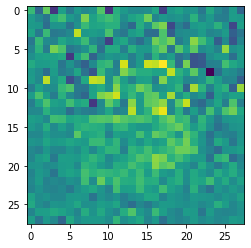

In [11]:
net_RealNVP.eval()
X = net_RealNVP.sample().cpu()
plt.imshow(X[0].view(IM_SHAPE).detach().numpy())

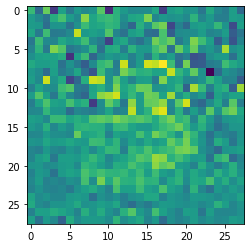

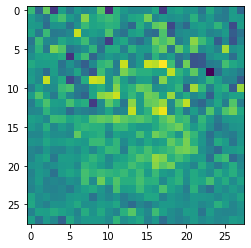

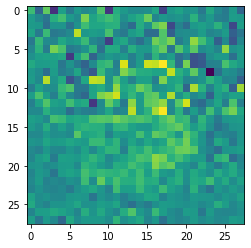

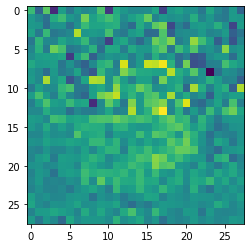

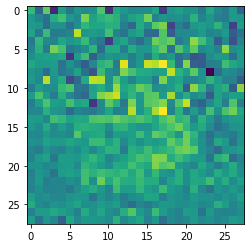

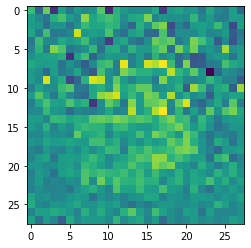

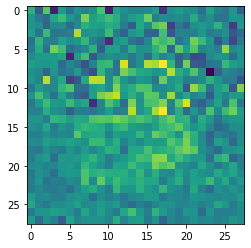

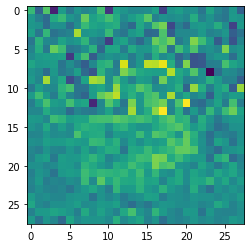

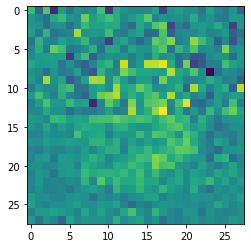

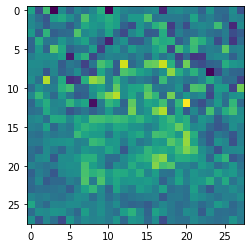

In [12]:
net_RealNVP.eval()
SAMPLES = 10
X = net_RealNVP.sample(SAMPLES).cpu()
for i in range(SAMPLES):
    plt.imshow(X[i].view(IM_SHAPE).detach().numpy())
    plt.show()
    